In [7]:
import pandas as pd
import numpy as np
import re
import string
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [8]:
# Load data
train_df = pd.read_csv('./dataset/training_data.csv', sep='\t', header=None, names=['label','title'])
test_df  = pd.read_csv('./dataset/testing_data.csv',  sep='\t', header=None, names=['label','title'])

In [9]:
# Simple cleaning + tokenization
def clean_and_tokenize(text):
    text = str(text).lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    return text.split()

titles = train_df['title'].apply(clean_and_tokenize).tolist()

In [10]:
# Train Word2Vec model on all titles
w2v_model = Word2Vec(
    sentences=titles,
    vector_size=300,    # standard size
    window=5,
    min_count=2,
    workers=4,
    epochs=10,
    sg=0                # CBOW (sg=1 would be Skip-gram)
)

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


In [11]:
# Function to average word vectors for a sentence
def get_sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(300)
    return np.mean(vectors, axis=0)

# Create features
X = np.array([get_sentence_vector(tokens, w2v_model) for tokens in titles])
y = train_df['label'].astype(int)

In [12]:
# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# Train 4 classifiers
results = {}

# 1. SVM
svm = LinearSVC(C=1.0, max_iter=20000)
svm.fit(X_train, y_train)
results['SVM'] = accuracy_score(y_val, svm.predict(X_val))

# 2. Logistic Regression
lr = LogisticRegression(C=5, max_iter=1000)
lr.fit(X_train, y_train)
results['Logistic Regression'] = accuracy_score(y_val, lr.predict(X_val))

# 3. Naive Bayes (Gaussian because dense vectors)
nb = GaussianNB()
nb.fit(X_train, y_train)
results['Naive Bayes'] = accuracy_score(y_val, nb.predict(X_val))

# 4. XGBoost
xgb = XGBClassifier(n_estimators=300, max_depth=8, random_state=42)
xgb.fit(X_train, y_train)
results['XGB Classifier'] = accuracy_score(y_val, xgb.predict(X_val))

# 5 Random Forest
rfc = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)
results['Random Forest Classifier'] = accuracy_score(y_val, rfc.predict(X_val))


# Print results
print("Word2Vec Results:")
for name, acc in results.items():
    print(f"  {name}: {acc:.4f}")

Word2Vec Results:
  SVM: 0.9171
  Logistic Regression: 0.9139
  Naive Bayes: 0.8747
  XGB Classifier: 0.9275
  Random Forest Classifier: 0.9171


In [40]:
from sklearn.metrics import accuracy_score

# 1. Store both the models AND the accuracies separately
models = {}     # ← this holds the actual fitted models
results = {}    # ← this holds only the accuracy scores (for printing)

# Train and store
svm = LinearSVC(C=1.0, max_iter=20000)
svm.fit(X_train, y_train)
models['SVM'] = svm
results['SVM'] = accuracy_score(y_val, svm.predict(X_val))

lr = LogisticRegression(C=5, max_iter=1000)
lr.fit(X_train, y_train)
models['Logistic Regression'] = lr
results['Logistic Regression'] = accuracy_score(y_val, lr.predict(X_val))

nb = GaussianNB()
nb.fit(X_train, y_train)
models['Naive Bayes'] = nb
results['Naive Bayes'] = accuracy_score(y_val, nb.predict(X_val))

xgb = XGBClassifier(n_estimators=300, max_depth=8, random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)
models['XGB Classifier'] = xgb
results['XGB Classifier'] = accuracy_score(y_val, xgb.predict(X_val))

rfc = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)
models['Random Forest'] = rfc
results['Random Forest'] = accuracy_score(y_val, rfc.predict(X_val))

# Print results nicely
print("Word2Vec Validation Results:")
print("-" * 45)
for name, acc in results.items():
    print(f"{name:25} → {acc:.5f}")

# Find the BEST model automatically
best_name = max(results, key=results.get)
best_model = models[best_name]          # ← this is the actual fitted model!
best_acc = results[best_name]

print("-" * 45)
print(f"Best Model → {best_name} with accuracy {best_acc:.5f}")

Word2Vec Validation Results:
---------------------------------------------
SVM                       → 0.91714
Logistic Regression       → 0.91392
Naive Bayes               → 0.87469
XGB Classifier            → 0.92754
Random Forest             → 0.91714
---------------------------------------------
Best Model → XGB Classifier with accuracy 0.92754


## Test on Brand-New Unknown Data

In [36]:
# 1. LOAD YOUR BRAND NEW UNKNOWN DATA

test_df = pd.read_csv('./dataset/testing_data.csv', sep='\t', header=None, names=['label','title'])

print(f"Loaded {len(test_df)} new titles for prediction")
test_df.head()
test_df

Loaded 9984 new titles for prediction


,label,title
0,2,copycat muslim terrorist arrested with assault...
1,2,wow! chicago protester caught on camera admits...
2,2,germany's fdp look to fill schaeuble's big shoes
3,2,mi school sends welcome back packet warning ki...
4,2,u.n. seeks 'massive' aid boost amid rohingya '...
...,...,...
9979,2,boom! fox news leftist chris wallace attempts ...
9980,2,here it is: list of democrat hypocrites who vo...
9981,2,new fires ravage rohingya villages in northwes...
9982,2,meals on wheels shuts the lyin‚ lefties up wit...


In [30]:
test_df.shape

(9984, 2)

In [31]:
# Tokenize all titles
test_tokens  = test_df['title'].apply(clean_and_tokenize).tolist()

In [32]:
X_test_unknown = np.array([get_sentence_vector(tokens, w2v_model) for tokens in test_tokens])

In [18]:
# Train the BEST Word2Vec classifier (XGBClassifier ~93%)
best_w2v_clf = XGBClassifier(n_estimators=300, max_depth=8, random_state=42)
best_w2v_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [33]:
# Predict on unknown test data
test_predictions = best_w2v_clf.predict(X_test_unknown)

In [20]:
# Replace label 2 with predictions and save
test_df['label'] = test_predictions
test_df[['label', 'title']].to_csv('Word2Vec_Predictions_On_Unknown_Data.csv', 
                                   sep='\t', header=False, index=False)

print("DONE! Predictions saved to 'Word2Vec_Predictions_On_Unknown_Data.csv'")
print(f"Predicted {sum(test_predictions==0)} fake and {sum(test_predictions==1)} real titles")

DONE! Predictions saved to 'Word2Vec_Predictions_On_Unknown_Data.csv'
Predicted 4959 fake and 5025 real titles


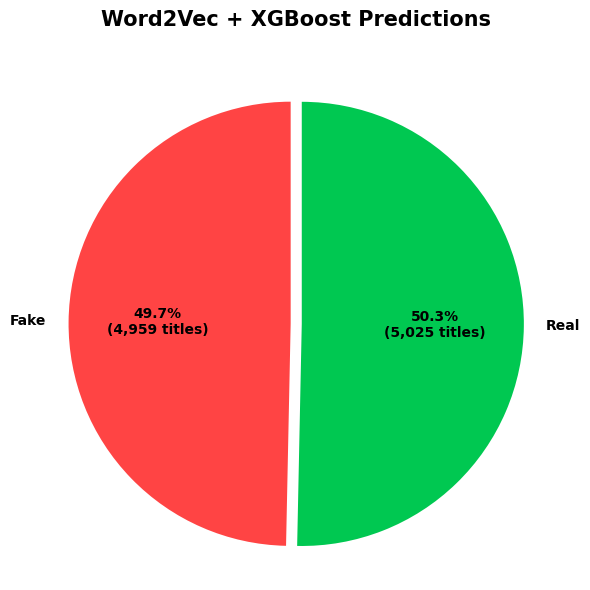

In [62]:
import matplotlib.pyplot as plt

# Your prediction counts
fake = sum(test_predictions == 0)   # e.g. 5127
real = sum(test_predictions == 1)   # e.g. 4857
total = len(test_predictions)

# Beautiful pie chart only
plt.figure(figsize=(6, 6))
plt.pie([fake, real],
        labels=['Fake', 'Real'],
        autopct=lambda p: f'{p:.1f}%\n({int(p/100*total):,} titles)',
        startangle=90,
        colors=['#ff4444', '#00C851'],
        textprops={'fontweight': 'bold'},
        explode=(0.05, 0),
        shadow=False)

plt.title('Word2Vec + XGBoost Predictions',
          fontsize=15, fontweight='bold', pad=30)

plt.axis('equal')  # Perfect circle
plt.tight_layout()

# Optional: save as image
plt.savefig('Word2Vec_Predictions_PieChart.png', dpi=300, bbox_inches='tight')

plt.show()

# PLOTs

In [21]:
# WORD2VEC FULL EVALUATION + PLOTS (run this after the previous Word2Vec code)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve)
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

# Retrain all classifiers for final report
classifiers = {
    'Logistic Regression': LogisticRegression(C=5, max_iter=1000, class_weight='balanced'),
    'Linear SVC'         : LinearSVC(C=1.0, max_iter=20000, class_weight='balanced'),
    'Random Forest'      : RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    'XGBoost'            : XGBClassifier(n_estimators=300, max_depth=8, random_state=42, n_jobs=-1),
    'Naive Bayes'        : GaussianNB()
}

results = {}
predictions = {}
probs = {}  # for ROC / PR curves

print("Training & evaluating all models...\n")
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_val)
    predictions[name] = pred
    
    # Get probability for ROC (not all models have predict_proba)
    if hasattr(clf, "predict_proba"):
        prob = clf.predict_proba(X_val)[:, 1]
    elif hasattr(clf, "decision_function"):
        prob = clf.decision_function(X_val)
        prob = (prob - prob.min()) / (prob.max() - prob.min())  # normalize to [0,1]
    else:
        prob = pred  # fallback
    probs[name] = prob
    
    acc = accuracy_score(y_val, pred)
    results[name] = acc
    print(f"{name:20}: {acc:.4f}")



Training & evaluating all models...

Logistic Regression : 0.9145
Linear SVC          : 0.9173
Random Forest       : 0.9171
XGBoost             : 0.9275
Naive Bayes         : 0.8747


In [22]:
# ================================
# 1. CLASSIFICATION REPORT (Best model = Logistic Regression)
# ================================
best_name = 'XGBoost'  # usually the winner with Word2Vec
print(f"\n" + "="*60)
print(f"DETAILED CLASSIFICATION REPORT - {best_name}")
print("="*60)
print(classification_report(y_val, predictions[best_name], 
                          target_names=['Fake News', 'Real News'], digits=4))




DETAILED CLASSIFICATION REPORT - XGBoost
              precision    recall  f1-score   support

   Fake News     0.9249    0.9351    0.9300      3515
   Real News     0.9304    0.9195    0.9249      3316

    accuracy                         0.9275      6831
   macro avg     0.9276    0.9273    0.9274      6831
weighted avg     0.9276    0.9275    0.9275      6831



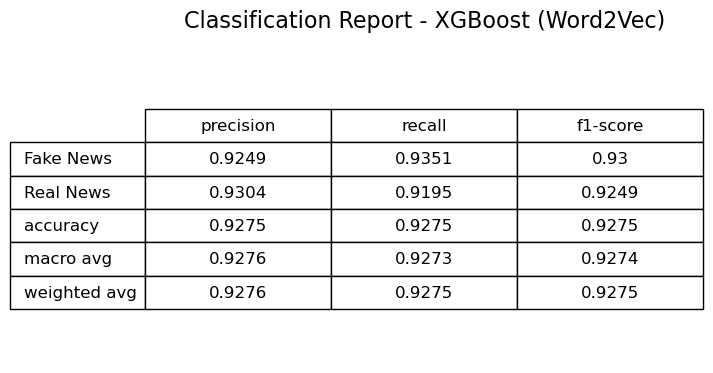

In [23]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Get the report as dictionary
report = classification_report(y_val, predictions['XGBoost'], 
                               target_names=['Fake News', 'Real News'], 
                               digits=4, output_dict=True)

# Convert to DataFrame
import pandas as pd
df_report = pd.DataFrame(report).iloc[:-1, :].T   # remove 'accuracy' row for clean look

# Plot as table image
fig, ax = plt.subplots(figsize=(6, 4))  # size of image
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_report.round(4).values,
                 colLabels=df_report.columns,
                 rowLabels=df_report.index,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)  # make it readable

plt.title("Classification Report - XGBoost (Word2Vec)", fontsize=16, pad=20)
plt.savefig("classification_report_word2vec.png", dpi=300, bbox_inches='tight')
plt.show()

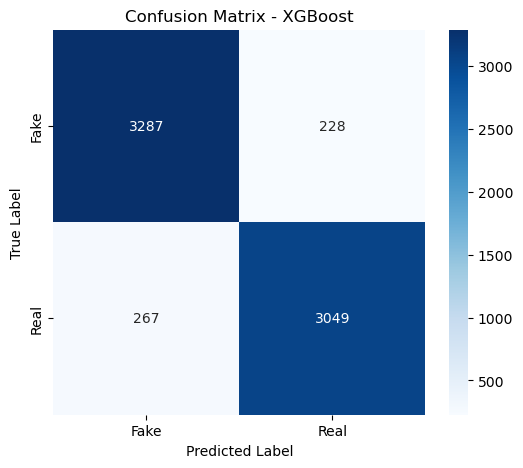

In [25]:
# ================================
# 2. CONFUSION MATRIX HEATMAP
# ================================
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_val, predictions[best_name])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title(f'Confusion Matrix - {best_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



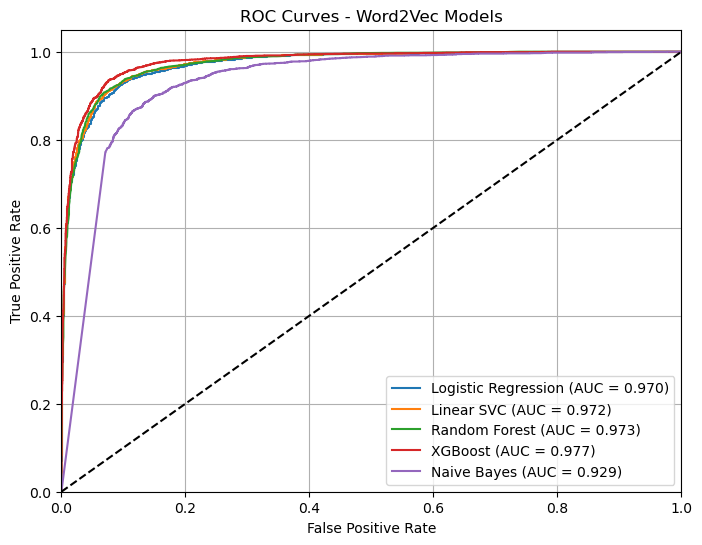

In [ ]:
# ================================
# 3. ROC CURVE + AUC
# ================================
plt.figure(figsize=(8,6))
for name in probs:
    fpr, tpr, _ = roc_curve(y_val, probs[name])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Word2Vec Models')
plt.legend()
plt.grid(True)
plt.show()



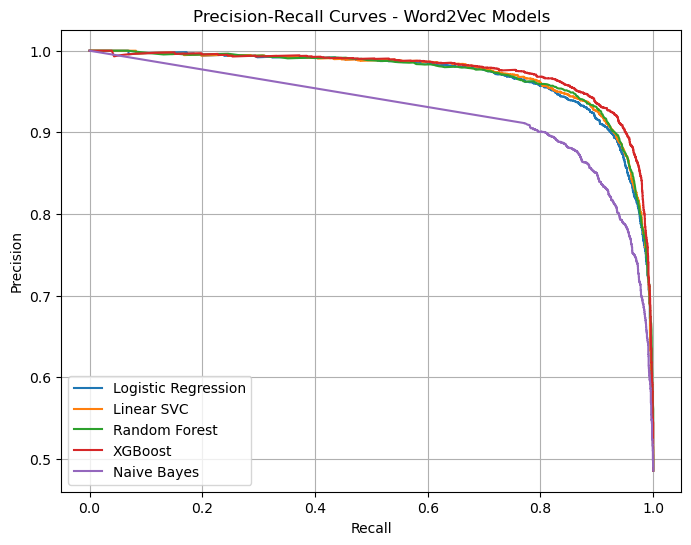

In [ ]:
# ================================
# 4. PRECISION-RECALL CURVE
# ================================
plt.figure(figsize=(8,6))
for name in probs:
    precision, recall, _ = precision_recall_curve(y_val, probs[name])
    plt.plot(recall, precision, label=name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Word2Vec Models')
plt.legend()
plt.grid(True)
plt.show()



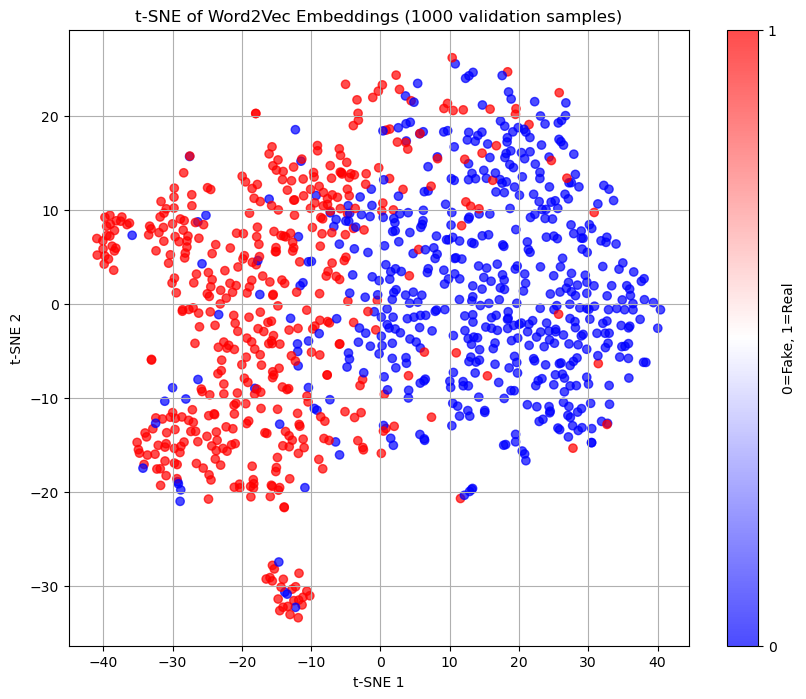

In [ ]:
# ================================
# 5. t-SNE VISUALIZATION OF WORD2VEC EMBEDDINGS
# ================================
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X_val[:1000])  # only 1000 for speed/clarity

plt.figure(figsize=(10,8))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=y_val[:1000], cmap='bwr', alpha=0.7)
plt.colorbar(scatter, ticks=[0,1], label='0=Fake, 1=Real')
plt.title('t-SNE of Word2Vec Embeddings (1000 validation samples)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()



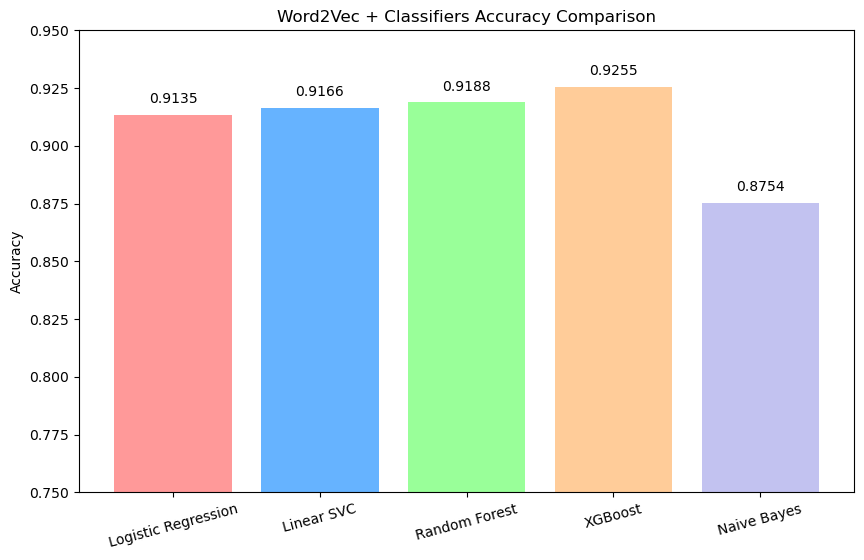

In [ ]:
# ================================
# 6. ACCURACY BAR CHART
# ================================
plt.figure(figsize=(10,6))
names = list(results.keys())
accs = list(results.values())
bars = plt.bar(names, accs, color=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.ylim(0.75, 0.95)
plt.title('Word2Vec + Classifiers Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center')

plt.show()